ENHANCED CNNBCN WITH HIERARCHICAL STRUCTURE

Visualizing Watts-Strogatz Graph and DAG conversion...


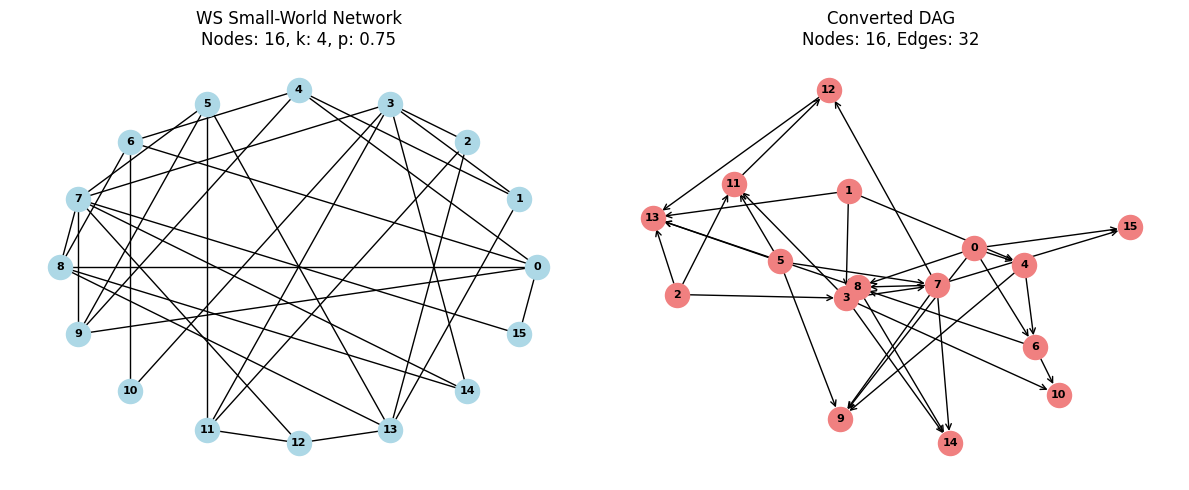

Watts-Strogatz Graph Statistics:
  Nodes: 16
  Edges: 32
  Average degree: 4.00
  Clustering coefficient: 0.1943
  Average shortest path length: 1.9250

Model Architecture Summary:
----------------------------------------
CNNBCN(
  (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (input_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_relu): ReLU(inplace=True)
  (modules_list): ModuleList(
    (0): CNNBCNModule(
      (node_ops): ModuleDict(
        (0): NodeOperation(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): GELU(approximate='none')
        )
        (1): NodeOperation(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runnin

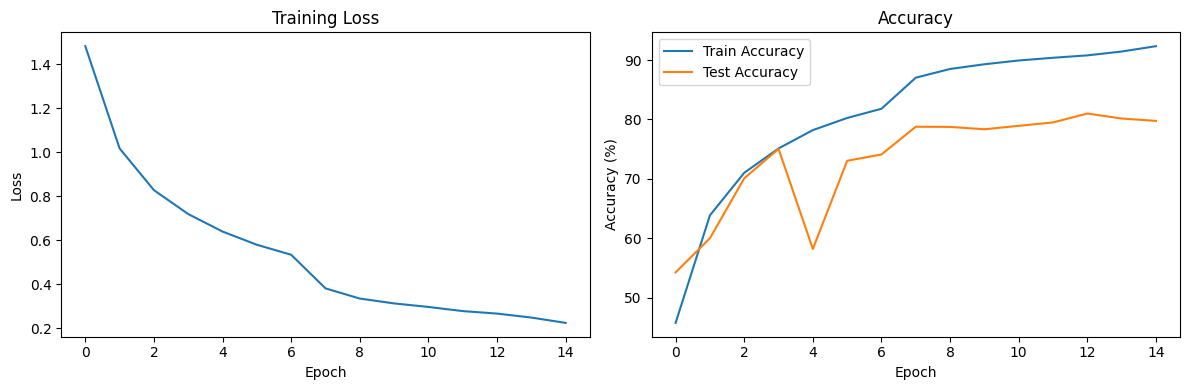


Training complete! Final test accuracy: 79.76%


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class DAGConverter:
    """Convert undirected graph to Directed Acyclic Graph"""

    def __init__(self):
        pass

    def convert_to_dag(self, graph: nx.Graph) -> nx.DiGraph:
        """
        Convert undirected graph to DAG by assigning indices and directing edges
        from smaller to larger index (as described in paper)
        """
        # Create directed graph
        dag = nx.DiGraph()

        # Add all nodes
        dag.add_nodes_from(graph.nodes())

        # Add directed edges from smaller to larger index
        for u, v in graph.edges():
            if u < v:
                dag.add_edge(u, v)
            else:
                dag.add_edge(v, u)

        return dag

class HierarchicalConnector:
    """
    Phase 1: Static Hierarchical Structure Implementation
    Creates strategic inter-module connections to enhance small-world properties
    """

    def __init__(self, num_modules: int, nodes_per_module: int):
        self.num_modules = num_modules
        self.nodes_per_module = nodes_per_module

    def create_hierarchical_connections(self, module_dags: List[nx.DiGraph]) -> Dict[str, List[Tuple[int, int]]]:
        """
        Create three types of inter-module connections:
        1. Hub-to-hub connections (primary backbone)
        2. Skip connections (functional bridges)
        3. Long-range shortcuts (small-world maintenance)

        Returns dictionary mapping connection types to lists of (module_idx, node_idx) pairs
        """
        connections = {
            'hub_to_hub': [],
            'skip_connections': [],
            'long_range_shortcuts': []
        }

        # Step 1: Identify hub nodes in each module
        hub_nodes = self._identify_hub_nodes(module_dags)

        # Step 2: Create hub-to-hub connections (primary backbone)
        connections['hub_to_hub'] = self._create_hub_connections(hub_nodes)

        # Step 3: Create skip connections between adjacent modules
        connections['skip_connections'] = self._create_skip_connections(module_dags)

        # Step 4: Create long-range shortcuts for global small-world property
        connections['long_range_shortcuts'] = self._create_long_range_shortcuts(module_dags)

        return connections

    def _identify_hub_nodes(self, module_dags: List[nx.DiGraph]) -> List[List[int]]:
        """
        Identify hub nodes in each module based on degree centrality
        Hub nodes are those with highest connectivity within their module
        """
        hub_nodes = []

        for dag in module_dags:
            # Calculate degree centrality for each node
            degree_centrality = nx.degree_centrality(dag.to_undirected())

            # Sort nodes by centrality and take top 3 as hubs
            sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
            module_hubs = [node for node, centrality in sorted_nodes[:3]]
            hub_nodes.append(module_hubs)

        return hub_nodes

    def _create_hub_connections(self, hub_nodes: List[List[int]]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """
        Create primary backbone connections between hub nodes of different modules
        These are the main pathways for global information flow
        """
        hub_connections = []

        # Connect primary hubs in sequential order (creates processing pipeline)
        for i in range(len(hub_nodes) - 1):
            # Connect primary hub of module i to primary hub of module i+1
            source = (i, hub_nodes[i][0])  # (module_idx, node_idx)
            target = (i + 1, hub_nodes[i + 1][0])
            hub_connections.append((source, target))

        # Create additional hub connections for better connectivity
        # Connect secondary hubs across modules
        for i in range(len(hub_nodes) - 1):
            if len(hub_nodes[i]) > 1 and len(hub_nodes[i + 1]) > 1:
                source = (i, hub_nodes[i][1])  # Secondary hub
                target = (i + 1, hub_nodes[i + 1][1])
                hub_connections.append((source, target))

        # Create cross-module connections (module 0 to module 3, module 1 to module 3)
        if len(hub_nodes) == 4:  # For 4-module architecture
            # Connect module 0 to module 3 (long-range connection)
            source = (0, hub_nodes[0][0])
            target = (3, hub_nodes[3][0])
            hub_connections.append((source, target))

            # Connect module 1 to module 3 (skip connection)
            source = (1, hub_nodes[1][0])
            target = (3, hub_nodes[3][0])
            hub_connections.append((source, target))

        return hub_connections

    def _create_skip_connections(self, module_dags: List[nx.DiGraph]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """
        Create functional skip connections between adjacent modules
        These connect functionally similar nodes across modules
        """
        skip_connections = []

        for i in range(len(module_dags) - 1):
            current_dag = module_dags[i]
            next_dag = module_dags[i + 1]

            # Get nodes with similar structural properties
            current_nodes = list(current_dag.nodes())
            next_nodes = list(next_dag.nodes())

            # Create connections based on node position similarity
            # Connect nodes at similar positions in the processing pipeline
            num_connections = min(4, len(current_nodes), len(next_nodes))

            for j in range(num_connections):
                # Use modulo to wrap around if fewer nodes available
                source_node = current_nodes[j % len(current_nodes)]
                target_node = next_nodes[j % len(next_nodes)]

                source = (i, source_node)
                target = (i + 1, target_node)
                skip_connections.append((source, target))

        return skip_connections

    def _create_long_range_shortcuts(self, module_dags: List[nx.DiGraph]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """
        Create random long-range shortcuts to maintain small-world properties
        These connections help reduce global path length
        """
        long_range_shortcuts = []

        # Create random connections between non-adjacent modules
        for i in range(len(module_dags)):
            for j in range(i + 2, len(module_dags)):  # Skip adjacent modules
                # Create 2 random connections between modules i and j
                for _ in range(2):
                    source_node = random.choice(list(module_dags[i].nodes()))
                    target_node = random.choice(list(module_dags[j].nodes()))

                    source = (i, source_node)
                    target = (j, target_node)
                    long_range_shortcuts.append((source, target))

        return long_range_shortcuts

class NodeOperation(nn.Module):
    """
    Enhanced Neural network node operation with hierarchical connection support
    Performs: Aggregation -> Transformation -> Distribution
    """

    def __init__(self, in_channels: int, out_channels: int, max_inputs: int = 12, use_gelu: bool = False):
        super(NodeOperation, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_inputs = max_inputs

        # Aggregation weights (learnable and positive via sigmoid)
        # Increased max_inputs to handle hierarchical connections
        self.aggregation_weights = nn.Parameter(torch.randn(max_inputs))

        # Transformation operations
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # Activation function (GeLU for first modules, ReLU for others as per paper)
        if use_gelu:
            self.activation = nn.GELU()
        else:
            self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass implementing the three steps from paper:
        1. Aggregation: weighted sum of inputs (now including hierarchical inputs)
        2. Transformation: conv + batch_norm + activation
        3. Distribution: output to next nodes
        """
        if not inputs:
            raise ValueError("Node must have at least one input")

        # Step 1: Aggregation with learnable weights
        if len(inputs) == 1:
            aggregated = inputs[0]
        else:
            # Limit the number of inputs to max_inputs to prevent index errors
            num_inputs = min(len(inputs), self.max_inputs)
            limited_inputs = inputs[:num_inputs]

            # Apply sigmoid to ensure positive weights
            weights = torch.sigmoid(self.aggregation_weights[:num_inputs])
            weights = weights / weights.sum()  # Normalize weights

            # Weighted sum of inputs
            aggregated = torch.zeros_like(limited_inputs[0])
            for i, inp in enumerate(limited_inputs):
                aggregated += weights[i] * inp

        # Step 2: Transformation
        x = self.conv(aggregated)
        x = self.batch_norm(x)
        x = self.activation(x)

        return x

class CNNBCNModule(nn.Module):
    """
    Enhanced CNNBCN module with hierarchical connection support
    """

    def __init__(self, dag: nx.DiGraph, in_channels: int, out_channels: int, use_gelu: bool = False, module_idx: int = 0):
        super(CNNBCNModule, self).__init__()
        self.dag = dag
        self.nodes = list(dag.nodes())
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.module_idx = module_idx

        # Calculate max inputs for any node (increased for hierarchical connections)
        max_inputs = max([dag.in_degree(node) for node in self.nodes] + [1])
        max_inputs = max(max_inputs, 12)  # Increased to handle hierarchical inputs

        # Create node operations
        self.node_ops = nn.ModuleDict()
        for node in self.nodes:
            self.node_ops[str(node)] = NodeOperation(in_channels, out_channels, max_inputs, use_gelu)

        # Input and output node mappings
        self.input_nodes = [node for node in self.nodes if dag.in_degree(node) == 0]
        self.output_nodes = [node for node in self.nodes if dag.out_degree(node) == 0]

        # If no natural input/output nodes, use first and last
        if not self.input_nodes:
            self.input_nodes = [min(self.nodes)]
        if not self.output_nodes:
            self.output_nodes = [max(self.nodes)]

        # Input projection to distribute input to input nodes
        self.input_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # Output aggregation
        if len(self.output_nodes) > 1:
            self.output_aggregation = nn.Conv2d(out_channels * len(self.output_nodes), out_channels, kernel_size=1)
        else:
            self.output_aggregation = None

    def forward(self, x: torch.Tensor, hierarchical_inputs: Dict[int, torch.Tensor] = None) -> Tuple[torch.Tensor, Dict[int, torch.Tensor]]:
        """
        Forward pass with hierarchical connection support

        Args:
            x: Primary input tensor
            hierarchical_inputs: Dictionary mapping node indices to hierarchical input tensors

        Returns:
            Tuple of (output_tensor, node_outputs_dict)
        """
        # Project input
        x_proj = self.input_projection(x)

        # Initialize node outputs
        node_outputs = {}

        # Topological sort for processing order
        topo_order = list(nx.topological_sort(self.dag))

        # Process nodes in topological order
        for node in topo_order:
            node_inputs = []

            if node in self.input_nodes:
                # Input nodes receive the projected input
                node_inputs.append(x_proj)
            else:
                # Collect inputs from predecessor nodes
                predecessors = list(self.dag.predecessors(node))
                for pred in predecessors:
                    if pred in node_outputs:
                        node_inputs.append(node_outputs[pred])

            # Add hierarchical inputs if available
            if hierarchical_inputs and node in hierarchical_inputs:
                node_inputs.append(hierarchical_inputs[node])

            if node_inputs:
                node_outputs[node] = self.node_ops[str(node)](node_inputs)

        # Aggregate outputs from output nodes
        output_tensors = [node_outputs[node] for node in self.output_nodes if node in node_outputs]

        if not output_tensors:
            # Fallback: use last computed node output
            output_tensors = [list(node_outputs.values())[-1]]

        if len(output_tensors) == 1:
            final_output = output_tensors[0]
        else:
            # Concatenate and aggregate multiple outputs
            concatenated = torch.cat(output_tensors, dim=1)
            final_output = self.output_aggregation(concatenated)

        return final_output, node_outputs

class CNNBCN(nn.Module):
    """
    Enhanced CNNBCN model with Phase 1 Static Hierarchical Structure
    """

    def __init__(self, num_classes: int = 10, num_modules: int = 4, nodes_per_module: int = 32):
        super(CNNBCN, self).__init__()

        self.num_modules = num_modules
        self.nodes_per_module = nodes_per_module

        # Generate random graphs and convert to DAGs for each module
        self.dags = []
        for i in range(num_modules):
            # Use NetworkX's watts_strogatz_graph
            # Parameters: n=nodes, k=nearest neighbors, p=rewiring probability
            # WS parameters as specified in paper: WS(Z=4, P=0.75)
            ws_graph = nx.watts_strogatz_graph(n=nodes_per_module, k=4, p=0.75, seed=42+i)

            # Convert to DAG
            dag_converter = DAGConverter()
            dag = dag_converter.convert_to_dag(ws_graph)
            self.dags.append(dag)

        # Create hierarchical connections
        self.hierarchical_connector = HierarchicalConnector(num_modules, nodes_per_module)
        self.hierarchical_connections = self.hierarchical_connector.create_hierarchical_connections(self.dags)

        # Channel progression (simple mode from paper: 78 channels)
        # For CIFAR-10, we'll use a smaller progression
        channels = [32, 64, 128, 256]  # Reduced from paper's 78 channels for efficiency

        # Input layer
        self.input_conv = nn.Conv2d(3, channels[0], kernel_size=3, padding=1)
        self.input_bn = nn.BatchNorm2d(channels[0])
        self.input_relu = nn.ReLU(inplace=True)

        # Enhanced CNNBCN modules with hierarchical support
        self.modules_list = nn.ModuleList()
        for i in range(num_modules):
            in_ch = channels[i] if i < len(channels) else channels[-1]
            out_ch = channels[i] if i < len(channels) else channels[-1]

            # Use GeLU for first two modules, ReLU for others (as per paper)
            use_gelu = i < 2

            module = CNNBCNModule(self.dags[i], in_ch, out_ch, use_gelu, module_idx=i)
            self.modules_list.append(module)

        # Hierarchical connection projections
        # These layers adapt features from different modules for hierarchical connections
        self.hierarchical_projections = nn.ModuleDict()
        for i in range(num_modules):
            for j in range(num_modules):
                if i != j:  # Don't create self-connections
                    # Create projection layer to match channel dimensions
                    source_channels = channels[i] if i < len(channels) else channels[-1]
                    target_channels = channels[j] if j < len(channels) else channels[-1]

                    proj_key = f"{i}_to_{j}"
                    self.hierarchical_projections[proj_key] = nn.Sequential(
                        nn.Conv2d(source_channels, target_channels, kernel_size=1),
                        nn.BatchNorm2d(target_channels),
                        nn.ReLU(inplace=True)
                    )

        # Downsampling layers between modules
        self.downsample_layers = nn.ModuleList()
        for i in range(num_modules - 1):
            if i < len(channels) - 1:
                downsample = nn.Sequential(
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(channels[i+1]),
                    nn.ReLU(inplace=True)
                )
            else:
                # If we have more modules than channel sizes, use identity or simple conv
                downsample = nn.Sequential(
                    nn.Conv2d(channels[-1], channels[-1], kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(channels[-1]),
                    nn.ReLU(inplace=True)
                )
            self.downsample_layers.append(downsample)

        # Global average pooling and classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(channels[-1], num_classes)
        )

    def _prepare_hierarchical_inputs(self, all_module_outputs: Dict[int, Dict[int, torch.Tensor]],
                                   current_module_idx: int, target_spatial_size: Tuple[int, int]) -> Dict[int, torch.Tensor]:
        """
        Prepare hierarchical inputs for the current module based on connections
        Resizes hierarchical inputs to match the target spatial size.
        """
        hierarchical_inputs = {}

        # Process all connection types
        for connection_type, connections in self.hierarchical_connections.items():
            for (source_module, source_node), (target_module, target_node) in connections:
                # Only process connections targeting the current module
                if target_module == current_module_idx:
                    # Check if source module has been processed
                    if source_module in all_module_outputs:
                        if source_node in all_module_outputs[source_module]:
                            source_output = all_module_outputs[source_module][source_node]

                            # Project to match target module's channel dimensions
                            proj_key = f"{source_module}_to_{target_module}"
                            if proj_key in self.hierarchical_projections:
                                projected_output = self.hierarchical_projections[proj_key](source_output)

                                # Resize the projected output to match the target spatial size
                                resized_output = F.adaptive_avg_pool2d(projected_output, target_spatial_size)

                                # Add to hierarchical inputs (accumulate if multiple connections to same node)
                                if target_node in hierarchical_inputs:
                                    hierarchical_inputs[target_node] = (hierarchical_inputs[target_node] + resized_output) / 2
                                else:
                                    hierarchical_inputs[target_node] = resized_output

        return hierarchical_inputs


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Enhanced forward pass with hierarchical connections
        """
        # Input processing
        x = self.input_conv(x)
        x = self.input_bn(x)
        x = self.input_relu(x)

        # Store all module outputs for hierarchical connections
        all_module_outputs = {}
        current_x = x

        # Pass through CNNBCN modules with hierarchical connections
        for i, module in enumerate(self.modules_list):
            # Determine the target spatial size for hierarchical inputs
            # This should match the spatial size of the primary input to the current module
            if i == 0:
                target_spatial_size = (x.size(2), x.size(3)) # Use input size for the first module
            else:
                 # For subsequent modules, the primary input is the downsampled output of the previous module
                 # We need to calculate the expected size after downsampling
                 # Assuming a stride of 2 and padding of 1 in downsampling layers
                 # Output size = floor((Input size - kernel_size + 2*padding) / stride) + 1
                 # For kernel_size=3, stride=2, padding=1: floor((Input size - 3 + 2*1) / 2) + 1 = floor((Input size - 1) / 2) + 1
                 # This is equivalent to ceil(Input size / 2) for odd input sizes and Input size / 2 for even input sizes.
                 # A simpler way is to get the spatial size from the output of the previous downsampling layer if available.
                 # However, to prepare inputs *before* the module forward pass, we need to predict the size.
                 # Let's assume the spatial size halves at each downsampling step for simplicity in this fix.
                 # A more robust solution might involve passing spatial sizes or using a dummy tensor.
                 # For this fix, we'll approximate the target size.
                 prev_module_output = all_module_outputs[i-1][list(self.dags[i-1].nodes())[0]] # Get a sample output from previous module
                 target_spatial_size = (prev_module_output.size(2) // 2, prev_module_output.size(3) // 2)


            # Prepare hierarchical inputs for current module
            hierarchical_inputs = self._prepare_hierarchical_inputs(all_module_outputs, i, target_spatial_size)


            # Forward pass through module with hierarchical inputs
            current_x, node_outputs = module(current_x, hierarchical_inputs)

            # Store outputs for future hierarchical connections
            all_module_outputs[i] = node_outputs

            # Downsample between modules (except last)
            if i < len(self.downsample_layers):
                current_x = self.downsample_layers[i](current_x)

        # Global average pooling and classification
        x = self.global_avg_pool(current_x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

    def print_hierarchical_structure(self):
        """
        Print the hierarchical connection structure for analysis
        """
        print("\n" + "="*60)
        print("HIERARCHICAL CONNECTION STRUCTURE")
        print("="*60)

        for connection_type, connections in self.hierarchical_connections.items():
            print(f"\n{connection_type.upper().replace('_', ' ')}:")
            print("-" * 40)
            for (source_module, source_node), (target_module, target_node) in connections:
                print(f"  Module {source_module}, Node {source_node} -> Module {target_module}, Node {target_node}")

        print(f"\nTotal hierarchical connections: {sum(len(connections) for connections in self.hierarchical_connections.values())}")
        print("="*60)

def get_cifar10_dataloaders(batch_size: int = 64, num_workers: int = 2):
    """Get CIFAR-10 data loaders"""

    # Data transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, test_loader

def train_model(model, train_loader, test_loader, num_epochs=15, lr=0.001):
    """Train the enhanced CNNBCN model"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training history
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print(f"Training on device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}')

        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train

        # Test phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        test_acc = 100. * correct_test / total_test

        # Update learning rate
        scheduler.step()

        # Save metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Test Acc: {test_acc:.2f}%')
        print('-' * 50)

    return train_losses, train_accuracies, test_accuracies

def visualize_watts_strogatz_graph(n=32, k=4, p=0.75, seed=42):
    """Visualize the NetworkX Watts-Strogatz graph"""

    # Generate the graph
    ws_graph = nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed)

    plt.figure(figsize=(12, 5))

    # Plot 1: Original graph
    plt.subplot(1, 2, 1)
    pos = nx.circular_layout(ws_graph)  # Circular layout to show small-world structure
    nx.draw(ws_graph, pos, with_labels=True, node_color='lightblue',
            node_size=300, font_size=8, font_weight='bold')
    plt.title(f"WS Small-World Network\nNodes: {n}, k: {k}, p: {p}")
    plt.axis('off')

    # Plot 2: Convert to DAG and visualize
    plt.subplot(1, 2, 2)
    dag_converter = DAGConverter()
    dag = dag_converter.convert_to_dag(ws_graph)

    # Use hierarchical layout for DAG
    pos_dag = nx.spring_layout(dag, k=1, iterations=50)
    nx.draw(dag, pos_dag, with_labels=True, node_color='lightcoral',
            node_size=300, font_size=8, font_weight='bold',
            arrows=True, arrowsize=10, arrowstyle='->')
    plt.title(f"Converted DAG\nNodes: {dag.number_of_nodes()}, Edges: {dag.number_of_edges()}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print graph statistics
    print(f"Watts-Strogatz Graph Statistics:")
    print(f"  Nodes: {ws_graph.number_of_nodes()}")
    print(f"  Edges: {ws_graph.number_of_edges()}")
    print(f"  Average degree: {2 * ws_graph.number_of_edges() / ws_graph.number_of_nodes():.2f}")
    print(f"  Clustering coefficient: {nx.average_clustering(ws_graph):.4f}")

    # Only compute path length if graph is connected
    if nx.is_connected(ws_graph):
        print(f"  Average shortest path length: {nx.average_shortest_path_length(ws_graph):.4f}")
    else:
        print(f"  Graph is not connected - cannot compute average path length")

def analyze_dag_properties(dags):
    """Analyze properties of generated DAGs"""
    print("\nDAG Analysis:")
    print("=" * 30)

    for i, dag in enumerate(dags):
        print(f"\nModule {i+1} DAG:")
        print(f"  Nodes: {dag.number_of_nodes()}")
        print(f"  Edges: {dag.number_of_edges()}")

        # Calculate in-degree and out-degree statistics
        in_degrees = [dag.in_degree(node) for node in dag.nodes()]
        out_degrees = [dag.out_degree(node) for node in dag.nodes()]

        print(f"  Max in-degree: {max(in_degrees)}")
        print(f"  Max out-degree: {max(out_degrees)}")
        print(f"  Avg in-degree: {np.mean(in_degrees):.2f}")
        print(f"  Avg out-degree: {np.mean(out_degrees):.2f}")

        # Count input and output nodes
        input_nodes = [node for node in dag.nodes() if dag.in_degree(node) == 0]
        output_nodes = [node for node in dag.nodes() if dag.out_degree(node) == 0]

        print(f"  Input nodes: {len(input_nodes)} {input_nodes}")
        print(f"  Output nodes: {len(output_nodes)} {output_nodes}")

        # Check if DAG is valid (acyclic)
        if nx.is_directed_acyclic_graph(dag):
            print(f"  ✓ Valid DAG (acyclic)")
            # Calculate longest path
            try:
                longest_path = nx.dag_longest_path_length(dag)
                print(f"  Longest path length: {longest_path}")
            except:
                print("  Could not calculate longest path")
        else:
            print(f"  ⚠ Not a valid DAG (contains cycles)")

def main():
    """Main execution function"""
    print("="*60)
    print("ENHANCED CNNBCN WITH HIERARCHICAL STRUCTURE")
    print("="*60)

    # Visualize sample graph
    print("\nVisualizing Watts-Strogatz Graph and DAG conversion...")
    visualize_watts_strogatz_graph(n=16, k=4, p=0.75)  # Smaller for visualization

    # Create model
    num_classes = 10
    num_modules = 4
    nodes_per_module = 32  # Reduced from paper for computational efficiency

    model = CNNBCN(
        num_classes=num_classes,
        num_modules=num_modules,
        nodes_per_module=nodes_per_module
    )

    # Print model structure
    print("\nModel Architecture Summary:")
    print("-" * 40)
    print(model)

    # Analyze DAG properties
    analyze_dag_properties(model.dags)

    # Print hierarchical structure
    model.print_hierarchical_structure()

    # Get CIFAR-10 data loaders
    print("\nLoading CIFAR-10 dataset...")
    train_loader, test_loader = get_cifar10_dataloaders(batch_size=64)

    # Train the model
    print("\nStarting training...")
    train_losses, train_accs, test_accs = train_model(
        model,
        train_loader,
        test_loader,
        num_epochs=15,
        lr=0.001
    )

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('cnnbcn_results.png')
    plt.show()

    # Final evaluation
    final_test_acc = test_accs[-1]
    print(f"\nTraining complete! Final test accuracy: {final_test_acc:.2f}%")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class DAGConverter:
    """Convert undirected graph to Directed Acyclic Graph"""

    def __init__(self):
        pass

    def convert_to_dag(self, graph: nx.Graph) -> nx.DiGraph:
        """
        Convert undirected graph to DAG by assigning indices and directing edges
        from smaller to larger index (as described in paper)
        """
        # Create directed graph
        dag = nx.DiGraph()

        # Add all nodes
        dag.add_nodes_from(graph.nodes())

        # Add directed edges from smaller to larger index
        for u, v in graph.edges():
            if u < v:
                dag.add_edge(u, v)
            else:
                dag.add_edge(v, u)

        return dag

class HierarchicalConnector:
    """
    Phase 1: Static Hierarchical Structure Implementation
    Creates strategic inter-module connections to enhance small-world properties
    """

    def __init__(self, num_modules: int, nodes_per_module: int):
        self.num_modules = num_modules
        self.nodes_per_module = nodes_per_module

    def create_hierarchical_connections(self, module_dags: List[nx.DiGraph]) -> Dict[str, List[Tuple[int, int]]]:
        """
        Create three types of inter-module connections:
        1. Hub-to-hub connections (primary backbone)
        2. Skip connections (functional bridges)
        3. Long-range shortcuts (small-world maintenance)

        Returns dictionary mapping connection types to lists of (module_idx, node_idx) pairs
        """
        connections = {
            'hub_to_hub': [],
            'skip_connections': [],
            'long_range_shortcuts': []
        }

        # Step 1: Identify hub nodes in each module
        hub_nodes = self._identify_hub_nodes(module_dags)

        # Step 2: Create hub-to-hub connections (primary backbone)
        connections['hub_to_hub'] = self._create_hub_connections(hub_nodes)

        # Step 3: Create skip connections between adjacent modules
        connections['skip_connections'] = self._create_skip_connections(module_dags)

        # Step 4: Create long-range shortcuts for global small-world property
        connections['long_range_shortcuts'] = self._create_long_range_shortcuts(module_dags)

        return connections

    def _identify_hub_nodes(self, module_dags: List[nx.DiGraph]) -> List[List[int]]:
        """
        Identify hub nodes in each module based on degree centrality
        Hub nodes are those with highest connectivity within their module
        """
        hub_nodes = []

        for dag in module_dags:
            # Calculate degree centrality for each node
            degree_centrality = nx.degree_centrality(dag.to_undirected())

            # Sort nodes by centrality and take top 3 as hubs
            sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
            module_hubs = [node for node, centrality in sorted_nodes[:3]]
            hub_nodes.append(module_hubs)

        return hub_nodes

    def _create_hub_connections(self, hub_nodes: List[List[int]]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """
        Create primary backbone connections between hub nodes of different modules
        These are the main pathways for global information flow
        """
        hub_connections = []

        # Connect primary hubs in sequential order (creates processing pipeline)
        for i in range(len(hub_nodes) - 1):
            # Connect primary hub of module i to primary hub of module i+1
            source = (i, hub_nodes[i][0])  # (module_idx, node_idx)
            target = (i + 1, hub_nodes[i + 1][0])
            hub_connections.append((source, target))

        # Create additional hub connections for better connectivity
        # Connect secondary hubs across modules
        for i in range(len(hub_nodes) - 1):
            if len(hub_nodes[i]) > 1 and len(hub_nodes[i + 1]) > 1:
                source = (i, hub_nodes[i][1])  # Secondary hub
                target = (i + 1, hub_nodes[i + 1][1])
                hub_connections.append((source, target))

        # Create cross-module connections (module 0 to module 3, module 1 to module 3)
        if len(hub_nodes) == 4:  # For 4-module architecture
            # Connect module 0 to module 3 (long-range connection)
            source = (0, hub_nodes[0][0])
            target = (3, hub_nodes[3][0])
            hub_connections.append((source, target))

            # Connect module 1 to module 3 (skip connection)
            source = (1, hub_nodes[1][0])
            target = (3, hub_nodes[3][0])
            hub_connections.append((source, target))

        return hub_connections

    def _create_skip_connections(self, module_dags: List[nx.DiGraph]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """
        Create functional skip connections between adjacent modules
        These connect functionally similar nodes across modules
        """
        skip_connections = []

        for i in range(len(module_dags) - 1):
            current_dag = module_dags[i]
            next_dag = module_dags[i + 1]

            # Get nodes with similar structural properties
            current_nodes = list(current_dag.nodes())
            next_nodes = list(next_dag.nodes())

            # Create connections based on node position similarity
            # Connect nodes at similar positions in the processing pipeline
            num_connections = min(4, len(current_nodes), len(next_nodes))

            for j in range(num_connections):
                # Use modulo to wrap around if fewer nodes available
                source_node = current_nodes[j % len(current_nodes)]
                target_node = next_nodes[j % len(next_nodes)]

                source = (i, source_node)
                target = (i + 1, target_node)
                skip_connections.append((source, target))

        return skip_connections

    def _create_long_range_shortcuts(self, module_dags: List[nx.DiGraph]) -> List[Tuple[Tuple[int, int], Tuple[int, int]]]:
        """
        Create random long-range shortcuts to maintain small-world properties
        These connections help reduce global path length
        """
        long_range_shortcuts = []

        # Create random connections between non-adjacent modules
        for i in range(len(module_dags)):
            for j in range(i + 2, len(module_dags)):  # Skip adjacent modules
                # Create 2 random connections between modules i and j
                for _ in range(2):
                    source_node = random.choice(list(module_dags[i].nodes()))
                    target_node = random.choice(list(module_dags[j].nodes()))

                    source = (i, source_node)
                    target = (j, target_node)
                    long_range_shortcuts.append((source, target))

        return long_range_shortcuts

class NodeOperation(nn.Module):
    """
    Enhanced Neural network node operation with hierarchical connection support
    Performs: Aggregation -> Transformation -> Distribution
    """

    def __init__(self, in_channels: int, out_channels: int, max_inputs: int = 12, use_gelu: bool = False):
        super(NodeOperation, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_inputs = max_inputs

        # Aggregation weights (learnable and positive via sigmoid)
        # Increased max_inputs to handle hierarchical connections
        self.aggregation_weights = nn.Parameter(torch.randn(max_inputs))

        # Transformation operations
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # Activation function (GeLU for first modules, ReLU for others as per paper)
        if use_gelu:
            self.activation = nn.GELU()
        else:
            self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass implementing the three steps from paper:
        1. Aggregation: weighted sum of inputs (now including hierarchical inputs)
        2. Transformation: conv + batch_norm + activation
        3. Distribution: output to next nodes
        """
        if not inputs:
            raise ValueError("Node must have at least one input")

        # Step 1: Aggregation with learnable weights
        if len(inputs) == 1:
            aggregated = inputs[0]
        else:
            # Limit the number of inputs to max_inputs to prevent index errors
            num_inputs = min(len(inputs), self.max_inputs)
            limited_inputs = inputs[:num_inputs]

            # Apply sigmoid to ensure positive weights
            weights = torch.sigmoid(self.aggregation_weights[:num_inputs])
            weights = weights / weights.sum()  # Normalize weights

            # Weighted sum of inputs
            aggregated = torch.zeros_like(limited_inputs[0])
            for i, inp in enumerate(limited_inputs):
                aggregated += weights[i] * inp

        # Step 2: Transformation
        x = self.conv(aggregated)
        x = self.batch_norm(x)
        x = self.activation(x)

        return x

class CNNBCNModule(nn.Module):
    """
    Enhanced CNNBCN module with hierarchical connection support
    """

    def __init__(self, dag: nx.DiGraph, in_channels: int, out_channels: int, use_gelu: bool = False, module_idx: int = 0):
        super(CNNBCNModule, self).__init__()
        self.dag = dag
        self.nodes = list(dag.nodes())
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.module_idx = module_idx

        # Calculate max inputs for any node (increased for hierarchical connections)
        max_inputs = max([dag.in_degree(node) for node in self.nodes] + [1])
        max_inputs = max(max_inputs, 12)  # Increased to handle hierarchical inputs

        # Create node operations
        self.node_ops = nn.ModuleDict()
        for node in self.nodes:
            self.node_ops[str(node)] = NodeOperation(in_channels, out_channels, max_inputs, use_gelu)

        # Input and output node mappings
        self.input_nodes = [node for node in self.nodes if dag.in_degree(node) == 0]
        self.output_nodes = [node for node in self.nodes if dag.out_degree(node) == 0]

        # If no natural input/output nodes, use first and last
        if not self.input_nodes:
            self.input_nodes = [min(self.nodes)]
        if not self.output_nodes:
            self.output_nodes = [max(self.nodes)]

        # Input projection to distribute input to input nodes
        self.input_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # Output aggregation
        if len(self.output_nodes) > 1:
            self.output_aggregation = nn.Conv2d(out_channels * len(self.output_nodes), out_channels, kernel_size=1)
        else:
            self.output_aggregation = None

    def forward(self, x: torch.Tensor, hierarchical_inputs: Dict[int, torch.Tensor] = None) -> Tuple[torch.Tensor, Dict[int, torch.Tensor]]:
        """
        Forward pass with hierarchical connection support

        Args:
            x: Primary input tensor
            hierarchical_inputs: Dictionary mapping node indices to hierarchical input tensors

        Returns:
            Tuple of (output_tensor, node_outputs_dict)
        """
        # Project input
        x_proj = self.input_projection(x)

        # Initialize node outputs
        node_outputs = {}

        # Topological sort for processing order
        topo_order = list(nx.topological_sort(self.dag))

        # Process nodes in topological order
        for node in topo_order:
            node_inputs = []

            if node in self.input_nodes:
                # Input nodes receive the projected input
                node_inputs.append(x_proj)
            else:
                # Collect inputs from predecessor nodes
                predecessors = list(self.dag.predecessors(node))
                for pred in predecessors:
                    if pred in node_outputs:
                        node_inputs.append(node_outputs[pred])

            # Add hierarchical inputs if available
            if hierarchical_inputs and node in hierarchical_inputs:
                node_inputs.append(hierarchical_inputs[node])

            if node_inputs:
                node_outputs[node] = self.node_ops[str(node)](node_inputs)

        # Aggregate outputs from output nodes
        output_tensors = [node_outputs[node] for node in self.output_nodes if node in node_outputs]

        if not output_tensors:
            # Fallback: use last computed node output
            output_tensors = [list(node_outputs.values())[-1]]

        if len(output_tensors) == 1:
            final_output = output_tensors[0]
        else:
            # Concatenate and aggregate multiple outputs
            concatenated = torch.cat(output_tensors, dim=1)
            final_output = self.output_aggregation(concatenated)

        return final_output, node_outputs

class CNNBCN(nn.Module):
    """
    Enhanced CNNBCN model with Phase 1 Static Hierarchical Structure
    """

    def __init__(self, num_classes: int = 10, num_modules: int = 4, nodes_per_module: int = 32):
        super(CNNBCN, self).__init__()

        self.num_modules = num_modules
        self.nodes_per_module = nodes_per_module

        # Generate random graphs and convert to DAGs for each module
        self.dags = []
        for i in range(num_modules):
            # Use NetworkX's newman_watts_strogatz_graph
            # Parameters: n=nodes, k=nearest neighbors, p=rewiring probability
            # NW parameters: NW(Z=4, P=0.75) - same as WS for consistency
            nw_graph = nx.newman_watts_strogatz_graph(n=nodes_per_module, k=4, p=0.75, seed=42+i)

            # Convert to DAG
            dag_converter = DAGConverter()
            dag = dag_converter.convert_to_dag(nw_graph)
            self.dags.append(dag)

        # Create hierarchical connections
        self.hierarchical_connector = HierarchicalConnector(num_modules, nodes_per_module)
        self.hierarchical_connections = self.hierarchical_connector.create_hierarchical_connections(self.dags)

        # Channel progression (simple mode from paper: 78 channels)
        # For CIFAR-10, we'll use a smaller progression
        channels = [32, 64, 128, 256]  # Reduced from paper's 78 channels for efficiency

        # Input layer
        self.input_conv = nn.Conv2d(3, channels[0], kernel_size=3, padding=1)
        self.input_bn = nn.BatchNorm2d(channels[0])
        self.input_relu = nn.ReLU(inplace=True)

        # Enhanced CNNBCN modules with hierarchical support
        self.modules_list = nn.ModuleList()
        for i in range(num_modules):
            in_ch = channels[i] if i < len(channels) else channels[-1]
            out_ch = channels[i] if i < len(channels) else channels[-1]

            # Use GeLU for first two modules, ReLU for others (as per paper)
            use_gelu = i < 2

            module = CNNBCNModule(self.dags[i], in_ch, out_ch, use_gelu, module_idx=i)
            self.modules_list.append(module)

        # Hierarchical connection projections
        # These layers adapt features from different modules for hierarchical connections
        self.hierarchical_projections = nn.ModuleDict()
        for i in range(num_modules):
            for j in range(num_modules):
                if i != j:  # Don't create self-connections
                    # Create projection layer to match channel dimensions
                    source_channels = channels[i] if i < len(channels) else channels[-1]
                    target_channels = channels[j] if j < len(channels) else channels[-1]

                    proj_key = f"{i}_to_{j}"
                    self.hierarchical_projections[proj_key] = nn.Sequential(
                        nn.Conv2d(source_channels, target_channels, kernel_size=1),
                        nn.BatchNorm2d(target_channels),
                        nn.ReLU(inplace=True)
                    )

        # Downsampling layers between modules
        self.downsample_layers = nn.ModuleList()
        for i in range(num_modules - 1):
            if i < len(channels) - 1:
                downsample = nn.Sequential(
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(channels[i+1]),
                    nn.ReLU(inplace=True)
                )
            else:
                # If we have more modules than channel sizes, use identity or simple conv
                downsample = nn.Sequential(
                    nn.Conv2d(channels[-1], channels[-1], kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(channels[-1]),
                    nn.ReLU(inplace=True)
                )
            self.downsample_layers.append(downsample)

        # Global average pooling and classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(channels[-1], num_classes)
        )

    def _prepare_hierarchical_inputs(self, all_module_outputs: Dict[int, Dict[int, torch.Tensor]],
                                   current_module_idx: int, target_spatial_size: Tuple[int, int]) -> Dict[int, torch.Tensor]:
        """
        Prepare hierarchical inputs for the current module based on connections
        Resizes hierarchical inputs to match the target spatial size.
        """
        hierarchical_inputs = {}

        # Process all connection types
        for connection_type, connections in self.hierarchical_connections.items():
            for (source_module, source_node), (target_module, target_node) in connections:
                # Only process connections targeting the current module
                if target_module == current_module_idx:
                    # Check if source module has been processed
                    if source_module in all_module_outputs:
                        if source_node in all_module_outputs[source_module]:
                            source_output = all_module_outputs[source_module][source_node]

                            # Project to match target module's channel dimensions
                            proj_key = f"{source_module}_to_{target_module}"
                            if proj_key in self.hierarchical_projections:
                                projected_output = self.hierarchical_projections[proj_key](source_output)

                                # Resize the projected output to match the target spatial size
                                resized_output = F.adaptive_avg_pool2d(projected_output, target_spatial_size)

                                # Add to hierarchical inputs (accumulate if multiple connections to same node)
                                if target_node in hierarchical_inputs:
                                    hierarchical_inputs[target_node] = (hierarchical_inputs[target_node] + resized_output) / 2
                                else:
                                    hierarchical_inputs[target_node] = resized_output

        return hierarchical_inputs


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Enhanced forward pass with hierarchical connections
        """
        # Input processing
        x = self.input_conv(x)
        x = self.input_bn(x)
        x = self.input_relu(x)

        # Store all module outputs for hierarchical connections
        all_module_outputs = {}
        current_x = x

        # Pass through CNNBCN modules with hierarchical connections
        for i, module in enumerate(self.modules_list):
            # Determine the target spatial size for hierarchical inputs
            # This should match the spatial size of the primary input to the current module
            if i == 0:
                target_spatial_size = (x.size(2), x.size(3)) # Use input size for the first module
            else:
                 # For subsequent modules, the primary input is the downsampled output of the previous module
                 # We need to calculate the expected size after downsampling
                 # Assuming a stride of 2 and padding of 1 in downsampling layers
                 # Output size = floor((Input size - kernel_size + 2*padding) / stride) + 1
                 # For kernel_size=3, stride=2, padding=1: floor((Input size - 3 + 2*1) / 2) + 1 = floor((Input size - 1) / 2) + 1
                 # This is equivalent to ceil(Input size / 2) for odd input sizes and Input size / 2 for even input sizes.
                 # A simpler way is to get the spatial size from the output of the previous downsampling layer if available.
                 # However, to prepare inputs *before* the module forward pass, we need to predict the size.
                 # Let's assume the spatial size halves at each downsampling step for simplicity in this fix.
                 # A more robust solution might involve passing spatial sizes or using a dummy tensor.
                 # For this fix, we'll approximate the target size.
                 prev_module_output = all_module_outputs[i-1][list(self.dags[i-1].nodes())[0]] # Get a sample output from previous module
                 target_spatial_size = (prev_module_output.size(2) // 2, prev_module_output.size(3) // 2)


            # Prepare hierarchical inputs for current module
            hierarchical_inputs = self._prepare_hierarchical_inputs(all_module_outputs, i, target_spatial_size)


            # Forward pass through module with hierarchical inputs
            current_x, node_outputs = module(current_x, hierarchical_inputs)

            # Store outputs for future hierarchical connections
            all_module_outputs[i] = node_outputs

            # Downsample between modules (except last)
            if i < len(self.downsample_layers):
                current_x = self.downsample_layers[i](current_x)

        # Global average pooling and classification
        x = self.global_avg_pool(current_x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

    def print_hierarchical_structure(self):
        """
        Print the hierarchical connection structure for analysis
        """
        print("\n" + "="*60)
        print("HIERARCHICAL CONNECTION STRUCTURE")
        print("="*60)

        for connection_type, connections in self.hierarchical_connections.items():
            print(f"\n{connection_type.upper().replace('_', ' ')}:")
            print("-" * 40)
            for (source_module, source_node), (target_module, target_node) in connections:
                print(f"  Module {source_module}, Node {source_node} -> Module {target_module}, Node {target_node}")

        print(f"\nTotal hierarchical connections: {sum(len(connections) for connections in self.hierarchical_connections.values())}")
        print("="*60)

def get_cifar10_dataloaders(batch_size: int = 64, num_workers: int = 2):
    """Get CIFAR-10 data loaders"""

    # Data transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, test_loader

def train_model(model, train_loader, test_loader, num_epochs=15, lr=0.001):
    """Train the enhanced CNNBCN model"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training history
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print(f"Training on device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}')

        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train

        # Test phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        test_acc = 100. * correct_test / total_test

        # Update learning rate
        scheduler.step()

        # Save metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Test Acc: {test_acc:.2f}%')
        print('-' * 50)

    return train_losses, train_accuracies, test_accuracies

def visualize_newman_watts_graph(n=32, k=4, p=0.75, seed=42):
    """Visualize the NetworkX Newman-Watts graph"""

    # Generate the graph
    nw_graph = nx.newman_watts_strogatz_graph(n=n, k=k, p=p, seed=seed)

    plt.figure(figsize=(12, 5))

    # Plot 1: Original graph
    plt.subplot(1, 2, 1)
    pos = nx.circular_layout(nw_graph)  # Circular layout to show small-world structure
    nx.draw(nw_graph, pos, with_labels=True, node_color='lightgreen',
            node_size=300, font_size=8, font_weight='bold')
    plt.title(f"Newman-Watts Small-World Network\nNodes: {n}, k: {k}, p: {p}")
    plt.axis('off')

    # Plot 2: Convert to DAG and visualize
    plt.subplot(1, 2, 2)
    dag_converter = DAGConverter()
    dag = dag_converter.convert_to_dag(nw_graph)

    # Use hierarchical layout for DAG
    pos_dag = nx.spring_layout(dag, k=1, iterations=50)
    nx.draw(dag, pos_dag, with_labels=True, node_color='lightcoral',
            node_size=300, font_size=8, font_weight='bold',
            arrows=True, arrowsize=10, arrowstyle='->')
    plt.title(f"Converted DAG\nNodes: {dag.number_of_nodes()}, Edges: {dag.number_of_edges()}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print graph statistics
    print(f"Newman-Watts Graph Statistics:")
    print(f"  Nodes: {nw_graph.number_of_nodes()}")
    print(f"  Edges: {nw_graph.number_of_edges()}")
    print(f"  Average degree: {2 * nw_graph.number_of_edges() / nw_graph.number_of_nodes():.2f}")
    print(f"  Clustering coefficient: {nx.average_clustering(nw_graph):.4f}")

  # Only compute path length if graph is connected
    if nx.is_connected(nw_graph):
        print(f"  Average shortest path length: {nx.average_shortest_path_length(ws_graph):.4f}")
    else:
        print(f"  Graph is not connected - cannot compute average path length")

def analyze_dag_properties(dags):
    """Analyze properties of generated DAGs"""
    print("\nDAG Analysis:")
    print("=" * 30)

    for i, dag in enumerate(dags):
        print(f"\nModule {i+1} DAG:")
        print(f"  Nodes: {dag.number_of_nodes()}")
        print(f"  Edges: {dag.number_of_edges()}")

        # Calculate in-degree and out-degree statistics
        in_degrees = [dag.in_degree(node) for node in dag.nodes()]
        out_degrees = [dag.out_degree(node) for node in dag.nodes()]

        print(f"  Max in-degree: {max(in_degrees)}")
        print(f"  Max out-degree: {max(out_degrees)}")
        print(f"  Avg in-degree: {np.mean(in_degrees):.2f}")
        print(f"  Avg out-degree: {np.mean(out_degrees):.2f}")

        # Count input and output nodes
        input_nodes = [node for node in dag.nodes() if dag.in_degree(node) == 0]
        output_nodes = [node for node in dag.nodes() if dag.out_degree(node) == 0]

        print(f"  Input nodes: {len(input_nodes)} {input_nodes}")
        print(f"  Output nodes: {len(output_nodes)} {output_nodes}")

        # Check if DAG is valid (acyclic)
        if nx.is_directed_acyclic_graph(dag):
            print(f"  ✓ Valid DAG (acyclic)")
            # Calculate longest path
            try:
                longest_path = nx.dag_longest_path_length(dag)
                print(f"  Longest path length: {longest_path}")
            except:
                print("  Could not calculate longest path")
        else:
            print(f"  ⚠ Not a valid DAG (contains cycles)")

def main():
    """Main execution function"""
    print("="*60)
    print("ENHANCED CNNBCN WITH HIERARCHICAL STRUCTURE")
    print("="*60)

    # Visualize sample graph
    print("\nVisualizing newmann_watts Graph and DAG conversion...")
    visualize_newman_watts_graph(n=16, k=4, p=0.75)  # Smaller for visualization

    # Create model
    num_classes = 10
    num_modules = 4
    nodes_per_module = 32  # Reduced from paper for computational efficiency

    model = CNNBCN(
        num_classes=num_classes,
        num_modules=num_modules,
        nodes_per_module=nodes_per_module
    )

    # Print model structure
    print("\nModel Architecture Summary:")
    print("-" * 40)
    print(model)

    # Analyze DAG properties
    analyze_dag_properties(model.dags)

    # Print hierarchical structure
    model.print_hierarchical_structure()

    # Get CIFAR-10 data loaders
    print("\nLoading CIFAR-10 dataset...")
    train_loader, test_loader = get_cifar10_dataloaders(batch_size=64)

    # Train the model
    print("\nStarting training...")
    train_losses, train_accs, test_accs = train_model(
        model,
        train_loader,
        test_loader,
        num_epochs=15,
        lr=0.001
    )

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('cnnbcn_results.png')
    plt.show()

    # Final evaluation
    final_test_acc = test_accs[-1]
    print(f"\nTraining complete! Final test accuracy: {final_test_acc:.2f}%")

if __name__ == "__main__":
    main()